# 1. 라이브러리 로드

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

from scipy.io import loadmat
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# import mglearn
import itertools
from sklearn.metrics import silhouette_score
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
sns.set_style('white')

from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

fig = plt.figure(figsize = (30,20))
plt.rc('font', family='NanumBarunGothic') 

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

<Figure size 2160x1440 with 0 Axes>

# 2. 모델링 데이터셋 생성

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
filename = '/content/drive/My Drive/인공지능응용/data.csv'
data = pd.read_csv(filename)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# step 변수 -> 시간대 변수(hours)로 변경
# step 변수는 1step당 1시간 총 30일 (시뮬레이션 기간)

data['hours'] = data['step']%24
data.drop('step', axis='columns', inplace=True)
#data['hours'].value_counts()

In [6]:
# 거래 전, 후 잔액 값 차이를 나타내는 변수 생성 (송수신자 각각 변수)

# oldbalanceOrg 거래 전 초기 잔액
# newbalanceOrig 거래 후 새 잔액

# oldbalanceDest 거래 전 초기 잔액(수신자)
# newbalanceDest  거래 후 새 잔액(수신자)


data['diff_balanceOrig'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['diff_balanceDest'] = data['newbalanceDest'] - data['oldbalanceDest']

In [7]:
print('nameOrig의 unique한 값의 수 : ', len(data['nameOrig'].unique()))
print('nameDest의 unique한 값의 수 : ', len(data['nameDest'].unique()))

# data leakage 문제

nameOrig의 unique한 값의 수 :  6353307
nameDest의 unique한 값의 수 :  2722362


In [8]:
# name 변수 삭제
data = data.drop(['nameOrig', 'nameDest'], axis=1)
data

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hours,diff_balanceOrig,diff_balanceDest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,1,-9839.64,0.00
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1,-1864.28,0.00
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,1,-181.00,0.00
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,1,-181.00,-21182.00
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,1,-11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,23,-339682.13,339682.13
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,23,-6311409.28,0.00
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,23,-6311409.28,6311409.27
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,23,-850002.52,0.00


In [9]:
# type 변수 <- one-hot 인코딩 적용
data = pd.get_dummies(data, columns = ['type'], prefix='type')
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hours,diff_balanceOrig,diff_balanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,1,-9839.64,0.00,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,1,-1864.28,0.00,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,1,0,1,-181.00,0.00,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,1,0,1,-181.00,-21182.00,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,1,-11668.14,0.00,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,1,0,23,-339682.13,339682.13,0,1,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,1,0,23,-6311409.28,0.00,0,0,0,0,1
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,23,-6311409.28,6311409.27,0,1,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,1,0,23,-850002.52,0.00,0,0,0,0,1


In [10]:
# 열 순서 변경
data = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'hours',
       'diff_balanceOrig', 'diff_balanceDest', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'isFraud']]
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,hours,diff_balanceOrig,diff_balanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,9839.64,170136.0,160296.36,0.0,0.0,0,1,-9839.64,0.0,0,0,0,1,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,1,-1864.28,0.0,0,0,0,1,0,0
2,181.00,181.0,0.00,0.0,0.0,0,1,-181.00,0.0,0,0,0,0,1,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,-181.00,-21182.0,0,1,0,0,0,1
4,11668.14,41554.0,29885.86,0.0,0.0,0,1,-11668.14,0.0,0,0,0,1,0,0


In [11]:
# 추가_전처리
x = data.drop(['isFraud'], axis=1).values
y = data['isFraud'].values

features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'hours',
       'diff_balanceOrig', 'diff_balanceDest', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
pd.DataFrame(x, columns=features).head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,hours,diff_balanceOrig,diff_balanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,1.0,-9839.64,0.0,0.0,0.0,0.0,1.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1.0,-1864.28,0.0,0.0,0.0,0.0,1.0,0.0
2,181.00,181.0,0.00,0.0,0.0,0.0,1.0,-181.00,0.0,0.0,0.0,0.0,0.0,1.0
3,181.00,181.0,0.00,21182.0,0.0,0.0,1.0,-181.00,-21182.0,0.0,1.0,0.0,0.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,1.0,-11668.14,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# 추가_pca
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalDf['anomaly_indicator'] = y
principalDf.head()

,principal component1,principal component2,anomaly_indicator
0,-1.769115e+06,-733354.679558,0
1,-1.796365e+06,-936213.797780,0
2,-1.800194e+06,-964517.077117,1
3,-1.787166e+06,-965470.457103,1
4,-1.793064e+06,-914863.719696,0


<Figure size 432x288 with 0 Axes>

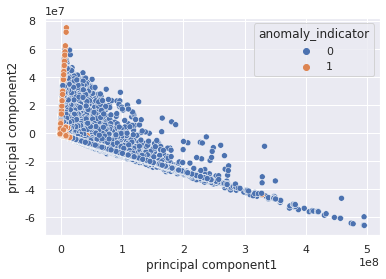

In [14]:
# 데이터 시각화 
plt.figure(figsize=(6, 4))
sns.scatterplot(principalDf['principal component1'], principalDf['principal component2'], hue=principalDf['anomaly_indicator'])

# 3. 탐색적 데이터 분석

In [12]:
# 추가_전처리
df = data
df = df.rename(columns={'isFraud':'anomaly_indicator'})
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,hours,diff_balanceOrig,diff_balanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,anomaly_indicator
0,9839.64,170136.0,160296.36,0.0,0.0,0,1,-9839.64,0.0,0,0,0,1,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,1,-1864.28,0.0,0,0,0,1,0,0
2,181.00,181.0,0.00,0.0,0.0,0,1,-181.00,0.0,0,0,0,0,1,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,-181.00,-21182.0,0,1,0,0,0,1
4,11668.14,41554.0,29885.86,0.0,0.0,0,1,-11668.14,0.0,0,0,0,1,0,0


In [13]:
# 추가_데이터 수정
df_normal = df[df['anomaly_indicator']==0]
df_abnormal = df[df['anomaly_indicator']==1]

Text(0.5, 1.0, 'amount')

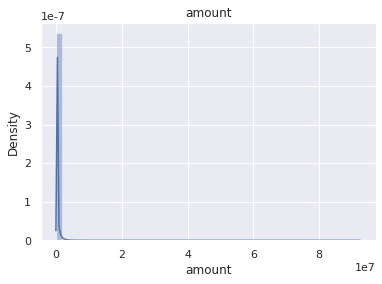

Text(0.5, 1.0, 'oldbalanceOrg')

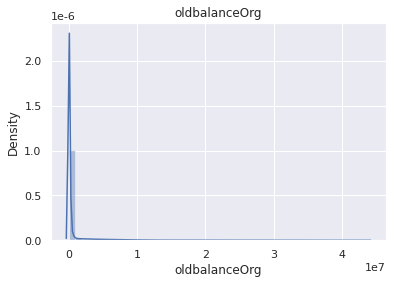

Text(0.5, 1.0, 'newbalanceOrig')

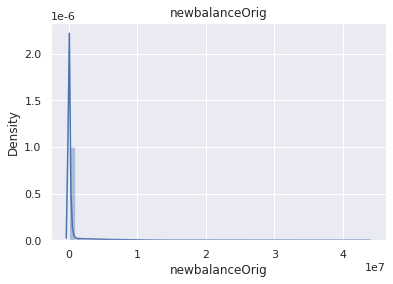

Text(0.5, 1.0, 'oldbalanceDest')

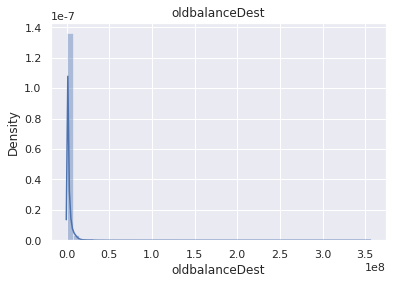

Text(0.5, 1.0, 'newbalanceDest')

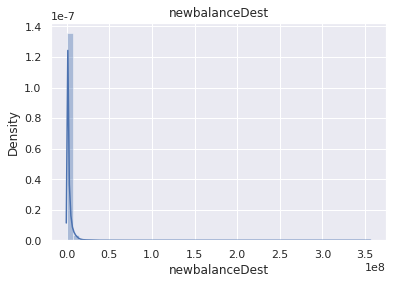

Text(0.5, 1.0, 'isFlaggedFraud')

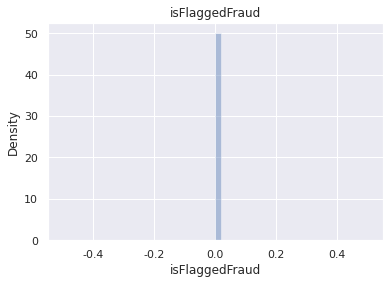

Text(0.5, 1.0, 'hours')

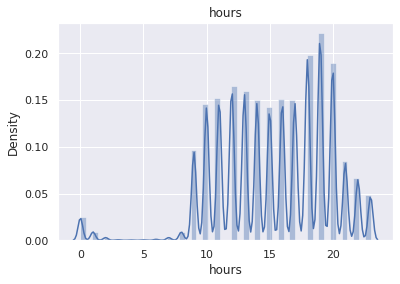

Text(0.5, 1.0, 'diff_balanceOrig')

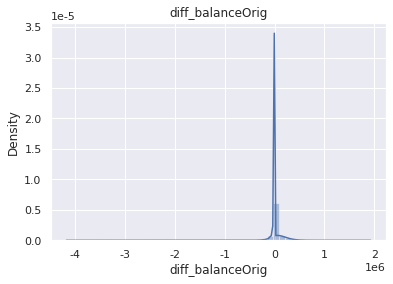

Text(0.5, 1.0, 'diff_balanceDest')

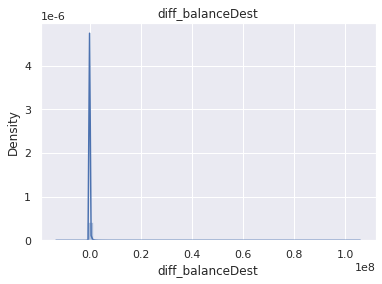

Text(0.5, 1.0, 'type_CASH_IN')

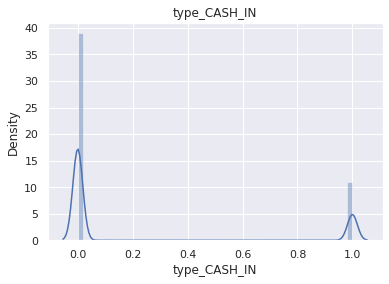

Text(0.5, 1.0, 'type_CASH_OUT')

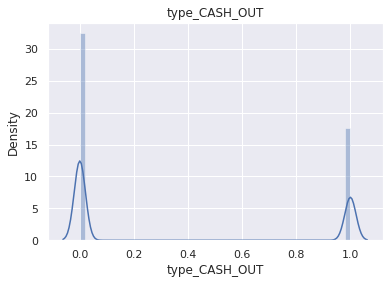

Text(0.5, 1.0, 'type_DEBIT')

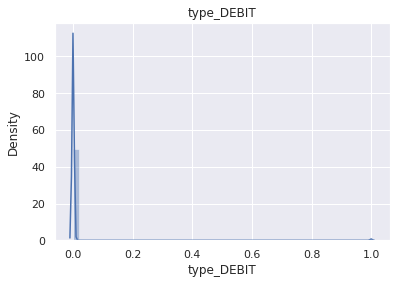

Text(0.5, 1.0, 'type_PAYMENT')

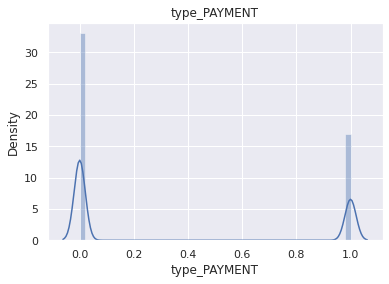

Text(0.5, 1.0, 'type_TRANSFER')

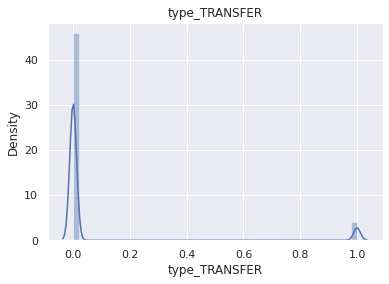

Text(0.5, 1.0, 'anomaly_indicator')

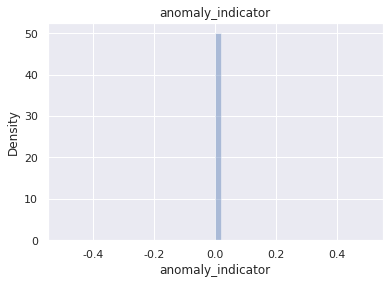

In [ ]:
# 정상 데이터의 변수별 분포 확인

for col in df.columns:
    sns.distplot(df_normal.loc[df_normal[col].notnull(), col])
    plt.title(col)
    plt.show()

Text(0.5, 1.0, 'amount')

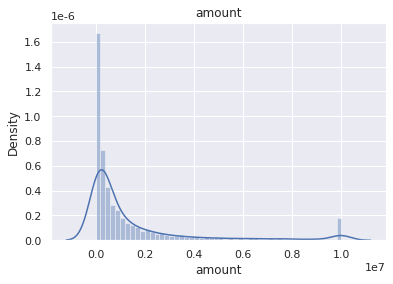

Text(0.5, 1.0, 'oldbalanceOrg')

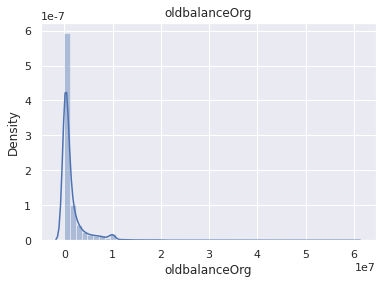

Text(0.5, 1.0, 'newbalanceOrig')

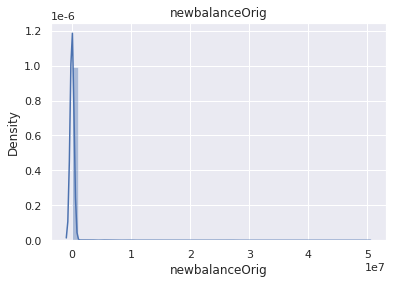

Text(0.5, 1.0, 'oldbalanceDest')

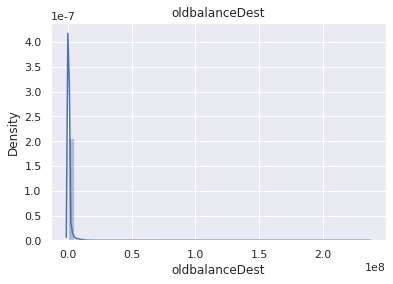

Text(0.5, 1.0, 'newbalanceDest')

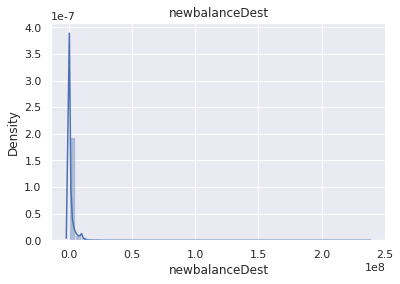

Text(0.5, 1.0, 'isFlaggedFraud')

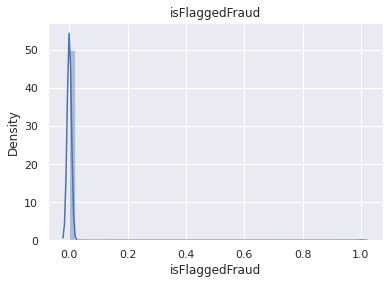

Text(0.5, 1.0, 'hours')

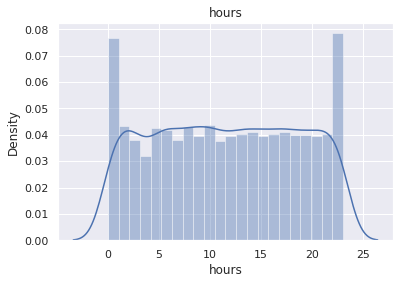

Text(0.5, 1.0, 'diff_balanceOrig')

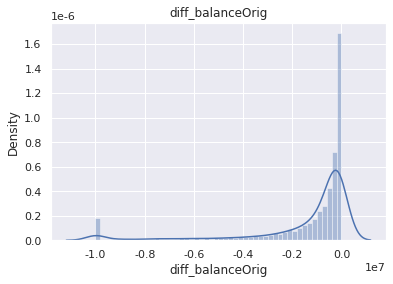

Text(0.5, 1.0, 'diff_balanceDest')

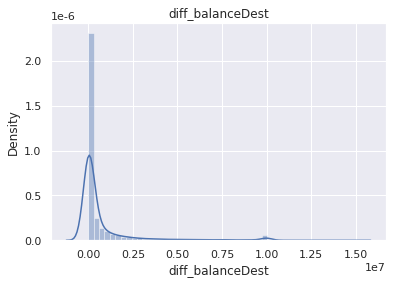

Text(0.5, 1.0, 'type_CASH_IN')

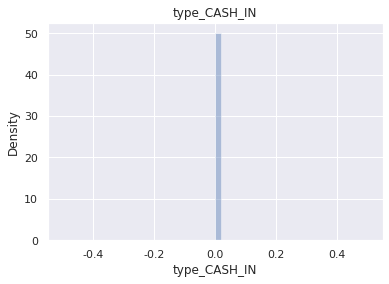

Text(0.5, 1.0, 'type_CASH_OUT')

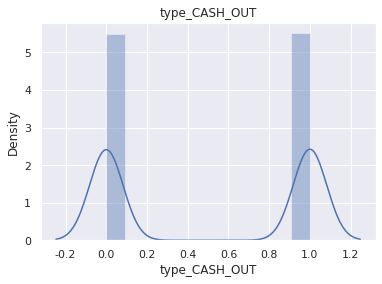

Text(0.5, 1.0, 'type_DEBIT')

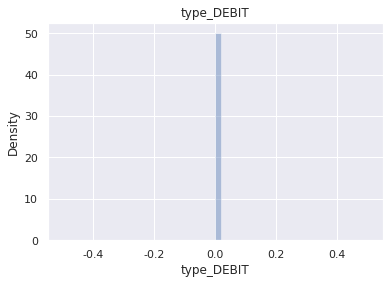

Text(0.5, 1.0, 'type_PAYMENT')

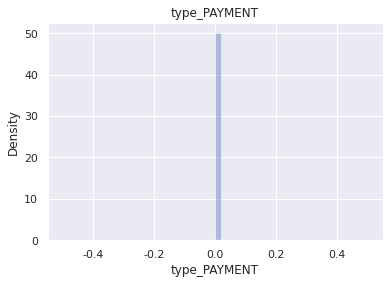

Text(0.5, 1.0, 'type_TRANSFER')

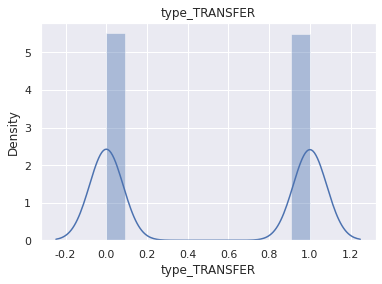

Text(0.5, 1.0, 'anomaly_indicator')

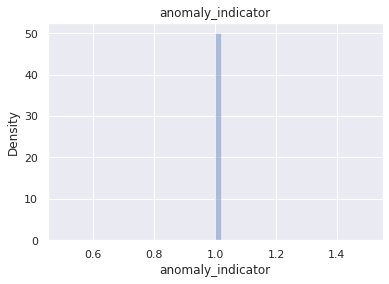

In [ ]:
# 이상 데이터의 변수별 분포 확인

for col in df.columns:
    sns.distplot(df_abnormal.loc[df_abnormal[col].notnull(), col])
    plt.title(col)
    plt.show()

<Figure size 720x144 with 0 Axes>

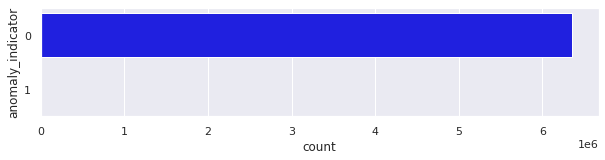

In [ ]:
# 정상 데이터와 이상 데이터 클래수 비교
plt.figure(figsize=(10,2))
fig = sns.countplot(y=df['anomaly_indicator'], data=df, palette=["blue", "red"])
plt.show()

In [14]:
# 정상 데이터의 100개 랜덤 샘플링 -> 개수 맞춰서 8213으로 샘플링
test_normal_df = df_normal.sample(n = 8213, random_state = 0)
test_normal_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,hours,diff_balanceOrig,diff_balanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,anomaly_indicator
1417484,265803.35,0.00,0.00,751669.39,1017472.74,0,19,0.00,265803.35,0,1,0,0,0,0
6216425,11278.28,0.00,0.00,220970.84,232249.12,0,13,0.00,11278.28,0,1,0,0,0,0
3906122,16363.06,35966.16,19603.10,0.00,0.00,0,20,-16363.06,0.00,0,0,0,1,0,0
731681,107223.31,20752629.71,20859853.02,804594.62,571711.22,0,13,107223.31,-232883.40,1,0,0,0,0,0
3949919,3678.25,0.00,0.00,0.00,0.00,0,23,0.00,0.00,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587444,4654.26,0.00,0.00,0.00,0.00,0,22,0.00,0.00,0,0,0,1,0,0
1871168,23351.97,0.00,0.00,0.00,0.00,0,20,0.00,0.00,0,0,0,1,0,0
1794731,7928.48,0.00,0.00,0.00,0.00,0,18,0.00,0.00,0,0,0,1,0,0
4840084,43458.67,20017.00,0.00,0.00,0.00,0,11,-20017.00,0.00,0,0,0,1,0,0


In [16]:
# 정상 데이터 100개 + 이상 데이터 concat 하여 test 데이터셋 생성
test_df = pd.concat([df_abnormal, test_normal_df])

# test 데이터 셋 => X_test, y_test 분할
X_test = test_df[test_df.columns.difference(['anomaly_indicator'])]
y_test = test_df["anomaly_indicator"]

print('X_test:', X_test.shape, 'y_test:', y_test.shape)

X_test: (16426, 14) y_test: (16426,)


In [17]:
# 나머지 900개 정상 데이터로 train 데이터셋 생성
train_df = df_normal.drop(test_normal_df.index)

# train 데이터 셋 => X_train, y_train 분할
X_train = train_df[train_df.columns.difference(['anomaly_indicator'])]
y_train = train_df["anomaly_indicator"]

print('X_train:', X_train.shape, 'y_train:', y_train.shape)

X_train: (6346194, 14) y_train: (6346194,)


<Figure size 720x144 with 0 Axes>

(0.0, 1000.0)

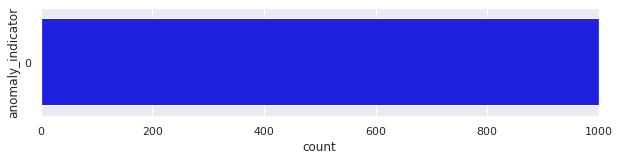

In [19]:
# train 데이터셋은 정상 데이터로만 구성
plt.figure(figsize=(10,2))
fig = sns.countplot(y=train_df['anomaly_indicator'], data=train_df, palette=["blue"])
plt.xlim(0, 1000)
plt.show()

<Figure size 720x144 with 0 Axes>

(0.0, 1000.0)

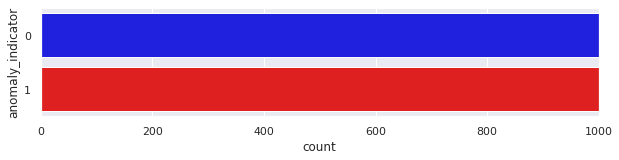

In [20]:
# test dataset은 정상과 이상 일대일 비율로 구성
plt.figure(figsize=(10,2))
fig = sns.countplot(y=test_df['anomaly_indicator'], data=test_df, palette=["blue", "red"])
plt.xlim(0, 1000)
plt.show()

# 4. 모델 구축

## 4-1. Isolation Forest

In [23]:
# Isolation Forest 모델 구축
IForest = IForest()
IForest.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [24]:
# train data에 대한 예측 값(정상=0, 이상=1)
IForest_train_pred = IForest.predict(X_train) 
IForest_train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
# test data에 대한 예측 값(정상=1, 이상=-1)
IForest_test_pred = IForest.predict(X_test) 
IForest_test_pred

array([0, 0, 0, ..., 0, 0, 0])

Text(30.5, 0.5, 'Actual')

Text(0.5, 12.5, 'Predicted')

accuracy:  0.7539267015706806
recall:  0.608
precision:  0.859
f1-score:  0.712


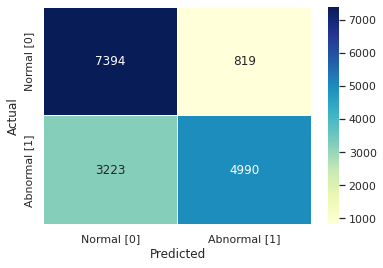

In [26]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, IForest_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, IForest_test_pred))
print("recall: ", round(recall_score(y_test, IForest_test_pred),3))
print("precision: ", round(precision_score(y_test, IForest_test_pred),3))
print("f1-score: ", round(f1_score(y_test, IForest_test_pred),3))

## 4-2. Local Outlier Factor

In [18]:
# LOF 모델 구축
LOF = LocalOutlierFactor(contamination=0.01,novelty=True)
LOF.fit(X_train)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [19]:
# train data에 대한 예측 값(정상=1, 이상=-1)
LOF_train_pred = LOF.predict(X_train) 
LOF_train_pred

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
# test data에 대한 예측 값(정상=1, 이상=-1)
LOF_test_pred = LOF.predict(X_test) 

LOF_test_pred = pd.DataFrame(LOF_test_pred)
LOF_test_pred = LOF_test_pred.replace({-1: 1, 1: 0})
LOF_test_pred 

,0
0,0
1,0
2,0
3,0
4,0
...,...
16421,0
16422,0
16423,0
16424,0


Text(30.5, 0.5, 'Actual')

Text(0.5, 12.5, 'Predicted')

accuracy:  0.6099476439790575
recall:  0.229
precision:  0.96
f1-score:  0.37


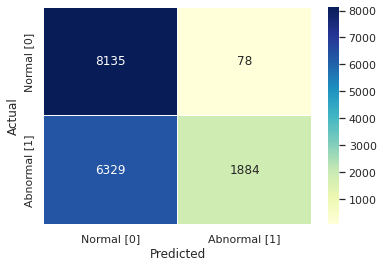

In [21]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, LOF_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, LOF_test_pred))
print("recall: ", round(recall_score(y_test, LOF_test_pred),3))
print("precision: ", round(precision_score(y_test, LOF_test_pred),3))
print("f1-score: ", round(f1_score(y_test, LOF_test_pred),3))

## 4-3. Pricipal Component Analysis

In [26]:
PCA = PCA()
PCA.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [27]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_train_pred = PCA.predict(X_train) 
PCA_train_pred

array([0, 0, 0, ..., 0, 0, 1])

In [28]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_test_pred = PCA.predict(X_test) 
PCA_test_pred

array([1, 0, 1, ..., 0, 0, 0])

Text(30.5, 0.5, 'Actual')

Text(0.5, 12.5, 'Predicted')

accuracy:  0.7827225130890052
recall:  0.665
precision:  0.87
f1-score:  0.754


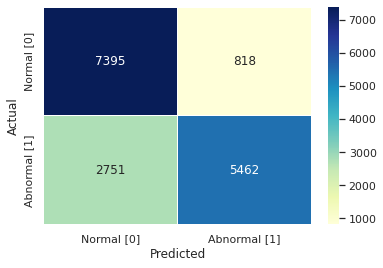

In [29]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, PCA_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, PCA_test_pred))
print("recall: ", round(recall_score(y_test, PCA_test_pred),3))
print("precision: ", round(precision_score(y_test, PCA_test_pred),3))
print("f1-score: ", round(f1_score(y_test, PCA_test_pred),3))

## 4-4. Auto-Encoder

In [30]:
input_dim = X_train.shape[1]

AE = tf.keras.models.Sequential([
    
    # encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

AE.compile(optimizer="adam", loss="mse")
AE.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 dense_1 (Dense)             (None, 4)                 60        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 14)                70        
                                                                 
Total params: 362
Trainable params: 362
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = AE.fit(
    X_train,
    X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.3
)

Epoch 1/100
138823/138823 [==============================] - 404s 3ms/step - loss: 51425595392.0000 - val_loss: 11025873920.0000
Epoch 2/100
138823/138823 [==============================] - 393s 3ms/step - loss: 13988005888.0000 - val_loss: 6767553536.0000
Epoch 3/100
138823/138823 [==============================] - 395s 3ms/step - loss: 10530707456.0000 - val_loss: 10037221376.0000
Epoch 4/100
138823/138823 [==============================] - 391s 3ms/step - loss: 9890445312.0000 - val_loss: 6725335040.0000
Epoch 5/100
138823/138823 [==============================] - 396s 3ms/step - loss: 9687280640.0000 - val_loss: 6653903360.0000
Epoch 6/100
138823/138823 [==============================] - 399s 3ms/step - loss: 9728925696.0000 - val_loss: 6344449024.0000
Epoch 7/100
138823/138823 [==============================] - 395s 3ms/step - loss: 9615987712.0000 - val_loss: 6268764672.0000
Epoch 8/100
138823/138823 [==============================] - 386s 3ms/step - loss: 9523991552.0000 - val_l

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# train data에 대한 예측 값
AE_train_pred = AE.predict(X_train)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의 -> Novelty Score
train_mse = np.mean(np.power(X_train - AE_train_pred, 2), axis=1)
train_mse = pd.DataFrame({'Reconstruction_error': train_mse})
train_mse

In [ ]:
# train 데이터에 대한 novelty score 기준 상위 10% 의 값을 임계치로 설정
AE_thresh = np.percentile(sorted(train_mse['Reconstruction_error']), 90)
AE_thresh

In [ ]:
plt.plot(train_mse)

In [ ]:
# test data에 대한 예측 값
AE_test_pred = AE.predict(X_test)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의
test_mse = np.mean(np.power(X_test - AE_test_pred, 2), axis=1)
test_mse

In [ ]:
plt.plot(test_mse.values)

In [ ]:
# classifier
# AE_thresh 기준, test_mse 값이 더 크면 이상(1), 작으면 정상(0)으로 분류
AE_test_df = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > AE_thresh:
            AE_test_df.append(1)
        else:
            AE_test_df.append(0)

In [ ]:
novelty_classifier(test_mse.values)

In [ ]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, AE_test_df) #confusion_matrix 함수 실행

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, AE_test_df))
print("recall: ", round(recall_score(y_test, AE_test_df),3))
print("precision: ", round(precision_score(y_test, AE_test_df),3))
print("f1-score: ", round(f1_score(y_test, AE_test_df),3))

## 4-5. Gaussian Density Estimation

In [ ]:
# gaussian 분포를 이용해 Outlier를 검출 모델
gde = EllipticEnvelope()
# 모델 fit
gde.fit(X_train)

In [ ]:
# train data에 대한 예측 값(정상=1, 이상=-1)
GDE_train_pred = gde.predict(X_train) 
GDE_train_pred

In [ ]:
# test data에 대한 예측 값(정상=1, 이상=-1)
GDE_test_pred = gde.predict(X_test) 
GDE_test_pred = pd.DataFrame(GDE_test_pred)
GDE_test_pred = GDE_test_pred.replace({-1: 1, 1: 0})
GDE_test_pred

In [ ]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, GDE_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 4-6. Mixture of Gaussian

In [ ]:
#Hyperparameter
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
print("covariance : ", best_gmm.covariance_type)
print("n_components : ", best_gmm.n_components)

In [ ]:
# 모델 fit
y_gmm = best_gmm.fit_predict(X)

In [ ]:
# test 각 샘플의 log-likelihood 계산
score = best_gmm.score_samples(X)

In [ ]:
# score column에 저장
df['score'] = score

In [ ]:
# threshold 설정(퍼센트) -> 이상치 4% 이상 값
pct_threshold = np.percentile(score, 4)
print(f'The threshold of the score is {pct_threshold:.2f}')

In [ ]:
# 이상치 레이블링
df['anomaly_gmm_pct'] = df['score'].apply(lambda x: 1 if x < pct_threshold else 0)

In [ ]:
# 예측한 이상치와 실제 값 그래프
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,12))
# 실제
ax0.set_title('Ground Truth')
ax0.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow')
# 예측
ax1.set_title('GMM Predict Anomalies Using Percentage')
ax1.scatter(df['feature1'], df['feature2'], c=df['anomaly_gmm_pct'], cmap='rainbow')

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 8))
# score 분포
sns.histplot(df['score'], bins=100, alpha=0.8)
# Threshold 값(값 지정)
plt.axvline(x=-7.76, color='orange')
value_threshold = -7.76
# 이상치 레이블링
df['anomaly_gmm_value'] = df['score'].apply(lambda x: 1 if x < value_threshold else 0)

In [ ]:
# test data에 대한 예측 값(정상=0, 이상=-1)
MOG_test_pred = best_gmm.predict(X_test) 
MOG_test_pred = pd.DataFrame(MOG_test_pred)
MOG_test_pred = MOG_test_pred.replace({1:0,2:0,3:0})
MOG_test_pred

In [ ]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, MOG_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 4-7. K-Nearst-Neighbors


In [ ]:
#Hyperparameter
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [ ]:
g_res = gs.fit(X_train, y_train)

In [ ]:
g_res.best_score_

In [ ]:
g_res.best_params_

In [ ]:
#값을 직접 입력
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',algorithm = 'brute',metric = 'minkowski')
knn.fit(X_train, y_train)

In [ ]:
KNN_train_pred = knn.predict(X_train)
KNN_train_pred

In [ ]:
KNN_test_pred = knn.predict(X_test)
KNN_test_pred

In [ ]:
#train, test 정확도 확인
print('Training set accuracy: ', metrics.accuracy_score(y_train, KNN_train_pred))
print('Test set accuracy: ',metrics.accuracy_score(y_test, KNN_test_pred))

In [ ]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, KNN_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
# 모델에서 k-neighbors의 거리 및 인덱스 출력 
distances, indexes = knn.kneighbors(X)
# 각 관측치의 k-거리에 대한 플롯 평균 
plt.plot(distances.mean(axis =1))

In [ ]:
# 컷오프 값을 시각적으로 결정 > 2 
outlier_index = np.where(distances.mean(axis = 1) > 2) 
outlier_index

In [ ]:
# 이상값 필터링 
outlier_values = df.iloc[outlier_index] 
outlier_values

In [ ]:
#정상 그래프
plt.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow', s = 65)

In [ ]:
#이상치 그래프
plt.scatter(outlier_values['feature1'], outlier_values['feature2'], c=outlier_values['anomaly_indicator'], cmap='rainbow')

In [ ]:
#이상 데이터 시각화
# 플롯 데이터 
plt.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow', s = 65)
# 이상값 플롯 
plt.scatter(outlier_values['feature1'], outlier_values['feature2'], c=outlier_values['anomaly_indicator'], cmap='rainbow')

## 4-8. K-Means

In [ ]:
# K-Means 클러스터링 함수 실행 후 차트 가시화
def k_Means_Plot(Data, Select_k, NAME, Init_Method = 'k-means++', Num_Init=10):
    global sum_of_squared_distance
    sum_of_squared_distance = []
    Data2 = Data[['feature1', 'feature2']]    
    fig, axes = plt.subplots(1, (np.max(list(Select_k))-np.min(list(Select_k)))+1, figsize=(15, 4))
    for i in Select_k:
        Kmeans_Clustering = KMeans(n_clusters=i, init=Init_Method, random_state=2020, n_init=Num_Init)
        Kmeans_Clustering.fit(Data2)
        mglearn.discrete_scatter(Data2['feature1'], Data2['feature2'], Kmeans_Clustering.labels_, ax=axes[i - 2], s=5)
        mglearn.discrete_scatter(Kmeans_Clustering.cluster_centers_[:, 0], 
                                 Kmeans_Clustering.cluster_centers_[:, 1],
                                 list(range(i)), 
                                 markeredgewidth=3, 
                                 ax=axes[i - 2], s=10)
        Score = np.round(silhouette_score(Data2, Kmeans_Clustering.labels_),2)
        axes[i - 2].set_title( NAME + ' / k = ' + str(i)+' / S_Score:'+str(Score))
        sum_of_squared_distance.append(Kmeans_Clustering.inertia_)

In [ ]:
for i in range(1,10,2):
    k_Means_Plot(Data = df,
                    Select_k = range(2, 6),
                    NAME = "DATASET",
                    Init_Method='random',Num_Init=i)

In [ ]:
for i in range(1,3):
    k_Means_Plot(Data = df,
                    Select_k = range(2, 10),
                    NAME = "DATASET",
                    Init_Method='random',Num_Init=i)

In [ ]:
#cluster 수 찾기
plt.figure(1 , figsize = (12, 6))
plt.plot(range(2, 10) , sum_of_squared_distance , 'o')
plt.plot(range(2, 10) , sum_of_squared_distance , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

In [ ]:
# 모델 fit
km = KMeans(n_clusters=3)
model = km.fit(X)

In [ ]:
colors=["red","blue","green","orange"]

In [ ]:
# 시각화
plt.figure(figsize=(8,6))
for i in range(np.max(model.labels_)+1):
    plt.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'], cmap='rainbow', s=40)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], label='Centers', c="black", s=100)
plt.title("K-Means Clustering of Customer Data",size=20)
plt.legend()
plt.show()

In [ ]:
# Outlier detection
# 각 센터에서 데이터의 거리를 계산
def distance_from_center(income, score, y, label) :
    center_income = model.cluster_centers_[label, 0]
    center_score = model.cluster_centers_[label, 1]
    dist = np.sqrt((income - center_income) ** 2 + (score - center_score))
    return np.round(dist, 3)

df['label'] = model.labels_
df['distance'] = distance_from_center(df.feature1, df.feature2, df.anomaly_indicator, df.label)

df.head()

In [ ]:
#군집에서 멀리 떨어진 데이터 확인->내림차순
outlier_indexs = list(df.sort_values('distance', ascending=False).head(10).index)
outliers = df[df.index.isin(outlier_indexs)]
print(outliers)

In [ ]:
# outlier 시각화
plt.figure(figsize=(8, 6))
for i in range(np.max(model.labels_)+1) :
    plt.scatter(df[model.labels_==i].feature1, df[model.labels_==i].feature2,
                c = df[model.labels_==i].anomaly_indicator, label=i, alpha=0.5)
plt.scatter(outliers.feature1, outliers.feature2, outliers.anomaly_indicator, c='darkred', marker='x')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
            label='Centers', c='pink', s=100)
plt.title('Outlier Detection with K-Means Clustering')
plt.legend()

plt.text(1.8, -2.6, f'predicted outliers : {len(outliers)}',fontdict={'color':'red', 'size':12})
plt.show()